In [1]:
import os
import sys
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_genai import ChatGoogleGenerativeAI
from agents.prompts import (
    agent1_prompt,
    agent2_prompt,
    agent3_prompt,
    thought_leadership_prompt,
    web_copy_prompt,
    email_sequence_prompt,
    social_post_prompt,
    sales_enablement_prompt,
    blog_post_prompt
)

from tools.search_tool import search_content

# --- Load environment variables ---
load_dotenv()

# --- Initialize LLM ---
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
# Alternative if you want to test with OpenAI:
# llm = ChatOpenAI(model="gpt-4o-mini")

tools = [search_content]
llm_with_tools = llm.bind_tools(tools)

# ============================================================
# 🧠 DEFINE INDIVIDUAL CONTENT AGENTS
# ============================================================

def thought_leadership_agent(state: MessagesState):
    return {"messages": [llm.invoke([SystemMessage(content=thought_leadership_prompt)] + state["messages"])]}

def web_copy_agent(state: MessagesState):
    return {"messages": [llm.invoke([SystemMessage(content=web_copy_prompt)] + state["messages"])]}

def email_sequence_agent(state: MessagesState):
    return {"messages": [llm.invoke([SystemMessage(content=email_sequence_prompt)] + state["messages"])]}

def social_post_agent(state: MessagesState):
    return {"messages": [llm.invoke([SystemMessage(content=social_post_prompt)] + state["messages"])]}

def sales_enablement_agent(state: MessagesState):
    return {"messages": [llm.invoke([SystemMessage(content=sales_enablement_prompt)] + state["messages"])]}

def blog_post_agent(state: MessagesState):
    return {"messages": [llm.invoke([SystemMessage(content=blog_post_prompt)] + state["messages"])]}

# ============================================================
# 🧭 ORCHESTRATOR
# ============================================================

orchestrator_prompt = SystemMessage(content="""
You are an orchestrator agent.
Your job is to decide which content type best fits the user’s intent.
Available content types:
- thought_leadership
- web_copy
- email_sequence
- social_post
- sales_enablement
- blog_post

Return ONLY one keyword exactly matching the best type.
""")

def orchestrator_agent(state: MessagesState):
    decision = llm.invoke([orchestrator_prompt] + state["messages"])
    decision_text = decision.content.strip().lower()

    valid_types = [
        "thought_leadership", "web_copy", "email_sequence",
        "social_post", "sales_enablement", "blog_post"
    ]
    next_node = decision_text if decision_text in valid_types else "blog_post"  # fallback

    print(f"🧭 Orchestrator chose: {next_node}")
    return {"messages": [decision], "next_node": next_node}

# ============================================================
# 🔍 SEARCH AGENT + TOOLS + TUNING AGENT
# ============================================================

search_agent_prompt = SystemMessage(content=agent1_prompt)
def search_agent(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([search_agent_prompt] + state["messages"])]}

content_agent_prompt = SystemMessage(content=agent2_prompt)
def content_agent(state: MessagesState):
    return {"messages": [llm.invoke([content_agent_prompt] + state["messages"])]}

tune_agent_prompt = SystemMessage(content=agent3_prompt)
def tune_agent(state: MessagesState):
    return {"messages": [llm.invoke([tune_agent_prompt] + state["messages"])]}

# ============================================================
# 🕸️ BUILD THE GRAPH
# ============================================================

graph = StateGraph(MessagesState)

# --- Add nodes ---
graph.add_node("search_agent", search_agent)
graph.add_node("tools", ToolNode(tools))
graph.add_node("orchestrator_agent", orchestrator_agent)
graph.add_node("tune_agent", tune_agent)

# --- Add all content-type agents ---
graph.add_node("thought_leadership", thought_leadership_agent)
graph.add_node("web_copy", web_copy_agent)
graph.add_node("email_sequence", email_sequence_agent)
graph.add_node("social_post", social_post_agent)
graph.add_node("sales_enablement", sales_enablement_agent)
graph.add_node("blog_post", blog_post_agent)

# --- Flow Setup ---
graph.add_edge(START, "search_agent")

graph.add_conditional_edges(
    "search_agent",
    tools_condition,
    {"tools": "tools", "__end__": "orchestrator_agent"}
)
graph.add_edge("tools", "search_agent")

# Orchestrator → correct agent
graph.add_conditional_edges(
    "orchestrator_agent",
    lambda state: state["next_node"],
    {
        "thought_leadership": "thought_leadership",
        "web_copy": "web_copy",
        "email_sequence": "email_sequence",
        "social_post": "social_post",
        "sales_enablement": "sales_enablement",
        "blog_post": "blog_post"
    }
)

# After generation → Tune → END
for node in ["thought_leadership", "web_copy", "email_sequence", "social_post", "sales_enablement", "blog_post"]:
    graph.add_edge(node, "tune_agent")

graph.add_edge("tune_agent", END)

# --- Compile the graph ---
agent = graph.compile()

# ============================================================
# 🧪 TEST RUN
# ============================================================
if __name__ == "__main__":
    test_message = HumanMessage(content="Create a LinkedIn post announcing our new AI-powered content marketing platform.")
    result = agent.invoke({"messages": [test_message]})
    print(result["messages"])


c:\Users\NextRow\anaconda3\envs\testEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


AttributeError: module 'tensorflow' has no attribute 'contrib'

In [3]:
import os
import sys
from dotenv import load_dotenv
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI # Kept for alternative

# Load environment variables
load_dotenv()

# --- Initialize LLM ---
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
# llm = ChatOpenAI(model="gpt-4o-mini") 



# Placeholder imports (replace with your actual imports)
class MockPrompt:
    def __init__(self, name): self.name = name
web_copy_prompt = MockPrompt("web_copy_prompt")
thought_leadership_prompt = MockPrompt("thought_leadership_prompt")
email_sequence_prompt = MockPrompt("email_sequence_prompt")
social_post_prompt = MockPrompt("social_post_prompt")
sales_enablement_prompt = MockPrompt("sales_enablement_prompt")
blog_post_prompt = MockPrompt("blog_post_prompt")
agent1_prompt = MockPrompt("agent1_prompt")
agent2_prompt = MockPrompt("agent2_prompt")
agent3_prompt = MockPrompt("agent3_prompt")
def search_content(query): return f"Search result for {query}"
# ----------------------------------------------------


# 1. 📝 DEFINE CUSTOM GRAPH STATE
# Add a key for the content type, which will be passed via HumanMessage kwargs.
class ContentAgentState(TypedDict):
    """
    Represents the state of the content generation graph.
    """
    messages: Annotated[List[BaseMessage], add_messages]
    # New key to store the user's explicit content choice or the LLM's decision
    final_content_type: str 
    # New key to determine the next node based on initial input
    initial_route: str


tools = [search_content]
llm_with_tools = llm.bind_tools(tools)

# ============================================================
# 🧠 DEFINE INDIVIDUAL CONTENT AGENTS (No change needed here)
# ============================================================
# ... (Your existing thought_leadership_agent, web_copy_agent, etc., functions go here)
# Keeping them as placeholders to show the flow:

def thought_leadership_agent(state: ContentAgentState):
    print(f"🧩 Executing THOUGHT LEADERSHIP Agent.")
    # Replace with your actual LLM call using the correct prompt
    return {"messages": [llm.invoke([SystemMessage(content=thought_leadership_prompt.name)] + state["messages"])]}

def web_copy_agent(state: ContentAgentState):
    print(f"🌐 Executing WEB COPY Agent.")
    return {"messages": [llm.invoke([SystemMessage(content=web_copy_prompt.name)] + state["messages"])]}

def email_sequence_agent(state: ContentAgentState):
    print(f"📧 Executing EMAIL SEQUENCE Agent.")
    return {"messages": [llm.invoke([SystemMessage(content=email_sequence_prompt.name)] + state["messages"])]}

def social_post_agent(state: ContentAgentState):
    print(f"💬 Executing SOCIAL POST Agent.")
    return {"messages": [llm.invoke([SystemMessage(content=social_post_prompt.name)] + state["messages"])]}

def sales_enablement_agent(state: ContentAgentState):
    print(f"📊 Executing SALES ENABLEMENT Agent.")
    return {"messages": [llm.invoke([SystemMessage(content=sales_enablement_prompt.name)] + state["messages"])]}

def blog_post_agent(state: ContentAgentState):
    print(f"📝 Executing BLOG POST Agent.")
    return {"messages": [llm.invoke([SystemMessage(content=blog_post_prompt.name)] + state["messages"])]}


# ============================================================
# 🧭 MODIFIED ORCHESTRATOR
# ============================================================

orchestrator_prompt = SystemMessage(content="""
You are an orchestrator agent.
Your job is to decide which content type best fits the user’s intent based on the topic and prior research.
Available content types: thought_leadership, web_copy, email_sequence, social_post, sales_enablement, blog_post.
Return ONLY one keyword exactly matching the best type.
""")

def orchestrator_agent(state: ContentAgentState):
    # This node only runs if the user did NOT pre-select a content type.
    print("🧭 Orchestrator LLM is running to DECIDE content type...")
    decision = llm.invoke([orchestrator_prompt] + state["messages"])
    decision_text = decision.content.strip().lower()

    valid_types = [
        "thought_leadership", "web_copy", "email_sequence",
        "social_post", "sales_enablement", "blog_post"
    ]
    # Set the next node and the final_content_type based on LLM output
    next_node = decision_text if decision_text in valid_types else "blog_post"  # fallback
    
    print(f"🧭 Orchestrator chose: **{next_node}**")
    
    # Update the final_content_type in the state for the next step (routing)
    return {"messages": [decision], "final_content_type": next_node}

# ============================================================
# ⚙️ INITIAL ROUTER NODE (NEW)
# ============================================================
def initial_router(state: ContentAgentState) -> str:
    """
    Routes the execution flow immediately after the search/tool use phase.
    If final_content_type is set (meaning the user chose it), skip orchestrator LLM.
    """
    if state["final_content_type"] and state["final_content_type"] != "let ai decide":
        print(f"⏩ User pre-selected content type: **{state['final_content_type']}**. Skipping Orchestrator LLM.")
        return state["final_content_type"]  # Route directly to the content agent
    else:
        print("🤔 User chose 'Let AI Decide'. Routing to **orchestrator_agent**.")
        return "orchestrator_agent" # Route to the LLM orchestrator for a decision


# ============================================================
# 🔍 SEARCH AGENT + TOOLS + TUNING AGENT (Use ContentAgentState)
# ============================================================
search_agent_prompt = SystemMessage(content=agent1_prompt.name)
def search_agent(state: ContentAgentState):
    return {"messages": [llm_with_tools.invoke([search_agent_prompt] + state["messages"])]}

# The tuning agent will be the final step (No change needed here)
tune_agent_prompt = SystemMessage(content=agent3_prompt.name)
def tune_agent(state: ContentAgentState):
    print("⚙️ Executing TUNE Agent.")
    return {"messages": [llm.invoke([tune_agent_prompt] + state["messages"])]}

# ============================================================
# 🕸️ BUILD THE GRAPH (Using ContentAgentState)
# ============================================================

graph = StateGraph(ContentAgentState)

# --- Add nodes ---
graph.add_node("search_agent", search_agent)
graph.add_node("tools", ToolNode(tools))
graph.add_node("orchestrator_agent", orchestrator_agent)
graph.add_node("tune_agent", tune_agent)

# --- Add all content-type agents ---
CONTENT_NODES = ["thought_leadership", "web_copy", "email_sequence", "social_post", "sales_enablement", "blog_post"]
graph.add_node("thought_leadership", thought_leadership_agent)
graph.add_node("web_copy", web_copy_agent)
graph.add_node("email_sequence", email_sequence_agent)
graph.add_node("social_post", social_post_agent)
graph.add_node("sales_enablement", sales_enablement_agent)
graph.add_node("blog_post", blog_post_agent)

# --- New Initial Routing Node ---
graph.add_node("initial_router", initial_router)

# --- Flow Setup ---
# 1. Start -> Search Agent
graph.add_edge(START, "search_agent")

# 2. Search Agent -> Tools OR Initial Router
graph.add_conditional_edges(
    "search_agent",
    tools_condition,
    {"tools": "tools", "__end__": "initial_router"} # Direct to Initial Router after search completes
)
graph.add_edge("tools", "search_agent")

# 3. Initial Router -> Orchestrator OR Direct Content Agent
# The conditional edges use the function's return value to route.
graph.add_conditional_edges(
    "initial_router",
    initial_router, # Reuse the initial_router function for conditional routing
    {
        "thought_leadership": "thought_leadership",
        "web_copy": "web_copy",
        "email_sequence": "email_sequence",
        "social_post": "social_post",
        "sales_enablement": "sales_enablement",
        "blog_post": "blog_post",
        "orchestrator_agent": "orchestrator_agent" # Route to LLM orchestrator if type was not set
    }
)

# 4. Orchestrator LLM -> Content Agent
# The orchestrator's output sets the 'final_content_type' which is used here
graph.add_conditional_edges(
    "orchestrator_agent",
    lambda state: state["final_content_type"], # Use the LLM's decision from the orchestrator node
    {
        "thought_leadership": "thought_leadership",
        "web_copy": "web_copy",
        "email_sequence": "email_sequence",
        "social_post": "social_post",
        "sales_enablement": "sales_enablement",
        "blog_post": "blog_post"
    }
)

# 5. Content Agent -> Tune Agent
for node in CONTENT_NODES:
    graph.add_edge(node, "tune_agent")

# 6. Tune Agent -> END
graph.add_edge("tune_agent", END)

# --- Compile the graph ---
agent = graph.compile()


# ============================================================
# 🚀 EXECUTION EXAMPLES
# ============================================================

# --- Helper function to prepare the input message ---
def prepare_input(topic: str, content_type: str) -> ContentAgentState:
    """Prepares the state for the LangGraph invocation."""
    
    # NOTE: The HumanMessage's content is the topic.
    # The pre-selected content type is stored in the custom state key.
    # We use HumanMessage.additional_kwargs to extract this in the graph's entry.
    # However, in LangGraph, it's cleaner to define the initial state directly.
    
    # Simulating the data passed from the frontend (Flask/JS)
    initial_messages = [HumanMessage(content=topic, additional_kwargs={"content_type": content_type})]
    
    # The LangGraph runtime will handle adding the first HumanMessage to 'messages'
    # We initialize 'final_content_type' with the user's selection for the Initial Router
    return {
        "messages": initial_messages,
        "final_content_type": content_type.lower() if content_type else "let ai decide",
        "initial_route": ""
    }


# 1. ⚙️ Test Case 1: User **PRE-SELECTS** content type ("social_post")
print("\n" + "="*80)
print("TEST CASE 1: User **PRE-SELECTS** Content Type (Social Post)")
print("="*80)
initial_state_1 = prepare_input(
    topic="The future of Python in cloud engineering.", 
    content_type="social_post" # This is passed to initial_router
)

# Run the flow - should skip orchestrator_agent
result_1 = agent.invoke(initial_state_1)
print("\n✅ Final Content for Test 1:", result_1["messages"][-1].content)


# 2. 🤖 Test Case 2: User selects **"Let AI Decide"** (content_type is empty/default)
print("\n" + "="*80)
print("TEST CASE 2: User selects **'Let AI Decide'** (Forces LLM Orchestrator)")
print("="*80)
initial_state_2 = prepare_input(
    topic="How to integrate AEM with Marketo for lead scoring.", 
    content_type="let ai decide" # This forces the LLM Orchestrator to run
)

# Run the flow - should run orchestrator_agent
# The Orchestrator LLM will decide the content type (e.g., 'blog_post')
result_2 = agent.invoke(initial_state_2)
print("\n✅ Final Content for Test 2:", result_2["messages"][-1].content)

ValueError: Function must have a docstring if description not provided.

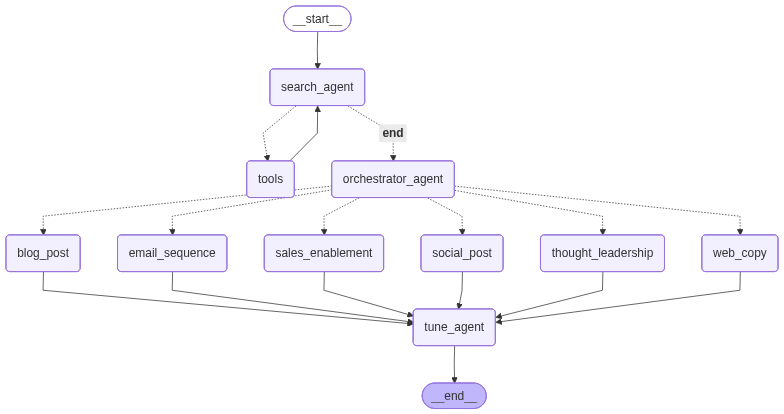

In [6]:
import os
import sys
from dotenv import load_dotenv
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI # Kept for alternative

# --- Placeholder definitions for external files ---
# In a real setup, these would be imported from agents/prompts.py and tools/search_tool.py
class MockPrompt:
    def __init__(self, name): self.name = name
    def __str__(self): return f"System Instruction for {self.name}"

thought_leadership_prompt = MockPrompt("Thought Leadership")
web_copy_prompt = MockPrompt("Web Copy")
email_sequence_prompt = MockPrompt("Email Sequence")
social_post_prompt = MockPrompt("Social Post")
sales_enablement_prompt = MockPrompt("Sales Enablement")
blog_post_prompt = MockPrompt("Blog Post")
agent1_prompt = MockPrompt("Search Agent")
agent2_prompt = MockPrompt("Content Agent")
agent3_prompt = MockPrompt("Tune Agent")

def search_content(query): 
    """Mock search tool, returning a result list for the tool node."""
    print(f"🔍 Executing search tool for: {query}")
    # Simulate a search result that the Search Agent can use
    return [
        {"source": "Wikipedia", "content": f"The latest findings on {query} show high complexity."},
        {"source": "Blog", "content": "Best practices for implementing {query}."}
    ]
# ----------------------------------------------------


# --- Load environment variables ---
load_dotenv()

# --- Initialize LLM ---
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
# llm = ChatOpenAI(model="gpt-4o-mini")




# ============================================================
# 1. 📝 DEFINE CUSTOM GRAPH STATE
# ============================================================

class ContentAgentState(TypedDict):
    """
    Represents the state of the content generation graph.
    """
    messages: Annotated[List[BaseMessage], add_messages]
    # New key to store the user's explicit content choice
    user_selected_type: str
    # Key to store the next node, used by the conditional edge
    next_node: str 


tools = [search_content]
llm_with_tools = llm.bind_tools(tools)


# ============================================================
# 🧠 DEFINE INDIVIDUAL CONTENT AGENTS (Using ContentAgentState)
# ============================================================

# Note: The functions are updated to accept the new state type, though their
# internal logic remains the same (just invoking the LLM with the system prompt)

def thought_leadership_agent(state: ContentAgentState):
    print(f"🧩 Executing THOUGHT LEADERSHIP Agent.")
    return {"messages": [llm.invoke([SystemMessage(content=str(thought_leadership_prompt))] + state["messages"])]}

def web_copy_agent(state: ContentAgentState):
    print(f"🌐 Executing WEB COPY Agent.")
    return {"messages": [llm.invoke([SystemMessage(content=str(web_copy_prompt))] + state["messages"])]}

def email_sequence_agent(state: ContentAgentState):
    print(f"📧 Executing EMAIL SEQUENCE Agent.")
    return {"messages": [llm.invoke([SystemMessage(content=str(email_sequence_prompt))] + state["messages"])]}

def social_post_agent(state: ContentAgentState):
    print(f"💬 Executing SOCIAL POST Agent.")
    return {"messages": [llm.invoke([SystemMessage(content=str(social_post_prompt))] + state["messages"])]}

def sales_enablement_agent(state: ContentAgentState):
    print(f"📊 Executing SALES ENABLEMENT Agent.")
    return {"messages": [llm.invoke([SystemMessage(content=str(sales_enablement_prompt))] + state["messages"])]}

def blog_post_agent(state: ContentAgentState):
    print(f"📝 Executing BLOG POST Agent.")
    return {"messages": [llm.invoke([SystemMessage(content=str(blog_post_prompt))] + state["messages"])]}

# ============================================================
# 🧭 MODIFIED ORCHESTRATOR (CORE CHANGE)
# ============================================================

orchestrator_prompt = SystemMessage(content="""
You are an orchestrator agent.
Your job is to decide which content type best fits the user’s intent based on the topic and prior research messages.
Available content types (return ONLY one keyword): thought_leadership, web_copy, email_sequence, social_post, sales_enablement, blog_post.
""")

def orchestrator_agent(state: ContentAgentState):
    """
    Decides the next node: either by bypassing to the user's choice, or by 
    running the LLM to decide, then setting the final 'next_node' for routing.
    """
    valid_types = [
        "thought_leadership", "web_copy", "email_sequence",
        "social_post", "sales_enablement", "blog_post"
    ]
    
    # Check for user's pre-selected type stored in the state
    user_choice = state.get("user_selected_type", "").strip().lower()

    if user_choice and user_choice in valid_types:
        # Scenario 1: User pre-selected content type (Bypass LLM)
        next_node = user_choice
        # We must return a message update for the graph to progress, 
        # but since we are bypassing the LLM, we use a simple HumanMessage as a log entry
        decision_message = HumanMessage(content=f"Routing based on user selection: {user_choice}")
        print(f"⏩ User pre-selected: **{user_choice}**. Skipping Orchestrator LLM.")
    else:
        # Scenario 2: LLM must decide
        print("🤔 User selected 'Let AI Decide' or no valid type found. Running Orchestrator LLM...")
        
        # Invoke the LLM to get the decision
        decision = llm.invoke([orchestrator_prompt] + state["messages"])
        decision_text = decision.content.strip().lower()
        
        # Set the next node based on LLM output (with a fallback)
        next_node = decision_text if decision_text in valid_types else "blog_post"
        decision_message = decision
        print(f"🧭 Orchestrator LLM chose: **{next_node}**")

    # The next_node key in the state is used by the conditional edge right after this node
    return {"messages": [decision_message], "next_node": next_node}

# ============================================================
# 🔍 SEARCH AGENT + TOOLS + TUNING AGENT (Using ContentAgentState)
# ============================================================

search_agent_prompt = SystemMessage(content=str(agent1_prompt))
def search_agent(state: ContentAgentState):
    return {"messages": [llm_with_tools.invoke([search_agent_prompt] + state["messages"])]}

# Note: Your original code included a 'content_agent' node which wasn't used. 
# It is excluded here to simplify the flow to match the original graph structure.

tune_agent_prompt = SystemMessage(content=str(agent3_prompt))
def tune_agent(state: ContentAgentState):
    print("⚙️ Executing TUNE Agent.")
    return {"messages": [llm.invoke([tune_agent_prompt] + state["messages"])]}

# ============================================================
# 🕸️ BUILD THE GRAPH (Using ContentAgentState)
# ============================================================

# 1. Initialize the graph with the custom state
graph = StateGraph(ContentAgentState)

# --- Add nodes ---
graph.add_node("search_agent", search_agent)
graph.add_node("tools", ToolNode(tools))
graph.add_node("orchestrator_agent", orchestrator_agent) # Now handles routing decision
graph.add_node("tune_agent", tune_agent)

# --- Add all content-type agents ---
CONTENT_NODES = ["thought_leadership", "web_copy", "email_sequence", "social_post", "sales_enablement", "blog_post"]
graph.add_node("thought_leadership", thought_leadership_agent)
graph.add_node("web_copy", web_copy_agent)
graph.add_node("email_sequence", email_sequence_agent)
graph.add_node("social_post", social_post_agent)
graph.add_node("sales_enablement", sales_enablement_agent)
graph.add_node("blog_post", blog_post_agent)

# --- Flow Setup ---
# 1. Start -> Search Agent
graph.add_edge(START, "search_agent")

# 2. Search Agent -> Tools OR Orchestrator Agent
# Once the search/tool-use phase is complete, execution MUST flow to the orchestrator_agent
graph.add_conditional_edges(
    "search_agent",
    tools_condition,
    {"tools": "tools", "__end__": "orchestrator_agent"} 
)
graph.add_edge("tools", "search_agent")

# 3. Orchestrator Agent -> Correct Content Agent
# The conditional edge now uses the 'next_node' value set by the orchestrator_agent function
graph.add_conditional_edges(
    "orchestrator_agent",
    lambda state: state["next_node"],
    {
        "thought_leadership": "thought_leadership",
        "web_copy": "web_copy",
        "email_sequence": "email_sequence",
        "social_post": "social_post",
        "sales_enablement": "sales_enablement",
        "blog_post": "blog_post"
    }
)

# 4. After generation -> Tune -> END
for node in CONTENT_NODES:
    graph.add_edge(node, "tune_agent")

graph.add_edge("tune_agent", END)

# --- Compile the graph ---
agent = graph.compile()
agent



In [7]:


import os
import sys
from dotenv import load_dotenv
from typing import TypedDict, List
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_genai import ChatGoogleGenerativeAI

# NOTE: Assuming these imports and files exist in your project structure
from agents.prompts import (
    agent1_prompt,
    agent2_prompt,
    agent3_prompt,
    thought_leadership_prompt,
    web_copy_prompt,
    email_sequence_prompt,
    social_post_prompt,
    sales_enablement_prompt,
    blog_post_prompt
)
from tools.search_tool import search_content

# --- Load environment variables ---
load_dotenv()

# --- Initialize LLM ---
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
# Alternative if you want to test with OpenAI:
# llm = ChatOpenAI(model="gpt-4o-mini")

# --- Dynamic Path Setup to set the default path  ---
current_file_path = os.path.abspath(__file__)
project_root = os.path.abspath(os.path.join(current_file_path, "../.."))
if project_root not in sys.path:
    sys.path.append(project_root)


tools = [search_content]
llm_with_tools = llm.bind_tools(tools)


# ============================================================
# ⚙️ DEFINE CUSTOM GRAPH STATE
# ============================================================

# Define a custom state that inherits from MessagesState (List[BaseMessage]) 
# and adds our new key 'initial_content_type' for conditional routing.
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    - messages: List of all messages passed so far.
    - next_node: Used by the orchestrator to decide the next step.
    - initial_content_type: Passed from the API/frontend to bypass the orchestrator.
    """
    messages: List[BaseMessage]
    next_node: str | None
    initial_content_type: str | None


# ============================================================
# 🧠 DEFINE INDIVIDUAL CONTENT AGENTS (No change needed here)
# ============================================================

def thought_leadership_agent(state: GraphState):
    return {"messages": [llm.invoke([SystemMessage(content=thought_leadership_prompt)] + state["messages"])]}

def web_copy_agent(state: GraphState):
    return {"messages": [llm.invoke([SystemMessage(content=web_copy_prompt)] + state["messages"])]}

def email_sequence_agent(state: GraphState):
    return {"messages": [llm.invoke([SystemMessage(content=email_sequence_prompt)] + state["messages"])]}

def social_post_agent(state: GraphState):
    return {"messages": [llm.invoke([SystemMessage(content=social_post_prompt)] + state["messages"])]}

def sales_enablement_agent(state: GraphState):
    return {"messages": [llm.invoke([SystemMessage(content=sales_enablement_prompt)] + state["messages"])]}

def blog_post_agent(state: GraphState):
    return {"messages": [llm.invoke([SystemMessage(content=blog_post_prompt)] + state["messages"])]}


# ============================================================
# 🧭 ORCHESTRATOR (No functional change, just type hint change)
# ============================================================

orchestrator_prompt = SystemMessage(content="""
You are an orchestrator agent.
Your job is to decide which content type best fits the user’s intent.
Available content types:
- thought_leadership
- web_copy
- email_sequence
- social_post
- sales_enablement
- blog_post

Return ONLY one keyword exactly matching the best type.
""")

def orchestrator_agent(state: GraphState):
    decision = llm.invoke([orchestrator_prompt] + state["messages"])
    decision_text = decision.content.strip().lower()

    valid_types = [
        "thought_leadership", "web_copy", "email_sequence",
        "social_post", "sales_enablement", "blog_post"
    ]
    next_node = decision_text if decision_text in valid_types else "blog_post"  # fallback

    print(f"🧭 Orchestrator chose: {next_node}")
    return {"messages": [decision], "next_node": next_node}


# ============================================================
# ⚙️ INITIAL ROUTER NODE (NEW LOGIC)
# ============================================================

VALID_CONTENT_TYPES = [
    "thought_leadership", "web_copy", "email_sequence",
    "social_post", "sales_enablement", "blog_post"
]

def initial_router(state: GraphState):
    """
    Decides whether to route to the Orchestrator or directly to the content agent.
    Bypasses the orchestrator if 'initial_content_type' is set and valid.
    """
    initial_type = state.get("initial_content_type")

    if initial_type and initial_type in VALID_CONTENT_TYPES:
        print(f"✅ Router chose direct path: {initial_type} (Skipping Orchestrator)")
        # The content-type name is the next node
        return initial_type 
    else:
        print("🧭 Router chose orchestrator (Content type not provided or invalid).")
        # Go to the orchestrator for automated selection
        return "orchestrator_agent" 


# ============================================================
# 🔍 SEARCH AGENT + TUNING AGENT (No change needed here)
# ============================================================

search_agent_prompt = SystemMessage(content=agent1_prompt)
def search_agent(state: GraphState):
    return {"messages": [llm_with_tools.invoke([search_agent_prompt] + state["messages"])]}

content_agent_prompt = SystemMessage(content=agent2_prompt)
def content_agent(state: GraphState):
    return {"messages": [llm.invoke([content_agent_prompt] + state["messages"])]}

tune_agent_prompt = SystemMessage(content=agent3_prompt)
def tune_agent(state: GraphState):
    return {"messages": [llm.invoke([tune_agent_prompt] + state["messages"])]}

# ============================================================
# 🕸️ BUILD THE GRAPH (REVISED FLOW)
# ============================================================

# Use the custom state class
graph = StateGraph(GraphState) 

# --- Add nodes ---
graph.add_node("search_agent", search_agent)
graph.add_node("tools", ToolNode(tools))
graph.add_node("initial_router", initial_router) # ADDED ROUTER
graph.add_node("orchestrator_agent", orchestrator_agent)
graph.add_node("tune_agent", tune_agent)

# --- Add all content-type agents ---
graph.add_node("thought_leadership", thought_leadership_agent)
graph.add_node("web_copy", web_copy_agent)
graph.add_node("email_sequence", email_sequence_agent)
graph.add_node("social_post", social_post_agent)
graph.add_node("sales_enablement", sales_enablement_agent)
graph.add_node("blog_post", blog_post_agent)

# --- Flow Setup ---
graph.add_edge(START, "search_agent")

graph.add_conditional_edges(
    "search_agent",
    tools_condition,
    {"tools": "tools", "__end__": "initial_router"} # CHANGE: After search/tools, go to the router
)
graph.add_edge("tools", "search_agent")

# NEW: Router decision logic - routes to orchestrator or a specific content agent
graph.add_conditional_edges(
    "initial_router",
    initial_router, # Uses the function itself as the conditional mapper
    {
        "orchestrator_agent": "orchestrator_agent",
        "thought_leadership": "thought_leadership",
        "web_copy": "web_copy",
        "email_sequence": "email_sequence",
        "social_post": "social_post",
        "sales_enablement": "sales_enablement",
        "blog_post": "blog_post"
    }
)

# Orchestrator → correct agent (Connects the orchestrator's decision to the agents)
graph.add_conditional_edges(
    "orchestrator_agent",
    lambda state: state["next_node"],
    {
        "thought_leadership": "thought_leadership",
        "web_copy": "web_copy",
        "email_sequence": "email_sequence",
        "social_post": "social_post",
        "sales_enablement": "sales_enablement",
        "blog_post": "blog_post"
    }
)

# After generation → Tune → END (Connects all content agents to the final tune agent)
for node in VALID_CONTENT_TYPES:
    graph.add_edge(node, "tune_agent")

graph.add_edge("tune_agent", END)

# --- Compile the graph ---
agent = graph.compile()


AttributeError: module 'tensorflow' has no attribute 'contrib'

In [5]:
import os
import sys
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_genai import ChatGoogleGenerativeAI
from agents.prompts import agent1_prompt,agent2_prompt,agent3_prompt,social_prompt,email_prompt,sales_prompt,thought_prompt,web_prompt,orchestrator_prompt

class ContentState(MessagesState):
    content_type:str




llm=ChatGoogleGenerativeAI(model="gemini-2.5-flash")

# llm = ChatOpenAI(model="gpt-4o-mini")
tools = [search_content]
llm_with_tools = llm.bind_tools(tools)

#  Define Agent 1: Search Agent 
search_agent_prompt = SystemMessage(content=agent1_prompt)
def search_agent(state: ContentState):
    print("--------------------------search agent state------------")
    print(state)
    return {"messages": [llm_with_tools.invoke([search_agent_prompt] + state["messages"])]}

def orchestrator(state: ContentState):
    return state

#  Define Agent 2: Content Agent 
blog_agent_prompt = SystemMessage(content=agent2_prompt)
def blog_agent(state: ContentState):
    print("--------------------------blog agent state------------")
    print(state["content_type"])
    return {"messages": [llm.invoke([blog_agent_prompt] + state["messages"])]}


thought_leadership_agent_prompt = SystemMessage(content=thought_prompt)
def thought_leadership_agent(state: ContentState):
    return {"messages": [llm.invoke([thought_leadership_agent_prompt] + state["messages"])]}


web_copy_agent_prompt = SystemMessage(content=web_prompt)
def web_copy_agent(state: ContentState):
    print(state["content_type"])
    return {"messages": [llm.invoke([web_copy_agent_prompt] + state["messages"])]}

email_sequence_agent_prompt = SystemMessage(content=email_prompt)

def email_sequence_agent(state: ContentState):
    return {"messages": [llm.invoke([email_sequence_agent_prompt] + state["messages"])]}


social_post_agent_prompt = SystemMessage(content=social_prompt)
def social_post_agent(state: ContentState):
    return {"messages": [llm.invoke([social_post_agent_prompt] + state["messages"])]}


sales_asset_agent_prompt = SystemMessage(content=sales_prompt)
def sales_asset_agent(state: ContentState):
    return {"messages": [llm.invoke([sales_asset_agent_prompt] + state["messages"])]}

# Define Agent 3: Tuning Agent 
tune_agent_prompt = SystemMessage(content=agent3_prompt)
def tune_agent(state: ContentState):
    return {"messages": [llm.invoke([tune_agent_prompt] + state["messages"])]}

def orchestrator_condition(state: ContentState):
    content_input = state["content_type"]
    prompt = orchestrator_prompt
    result = llm.invoke([HumanMessage(content=prompt)])
    response = result.content.strip().lower()

    # Sanity-check fallback
    valid_types = {
        "blog",
        "thought_leadership",
        "email_sequence",
        "web_copy",
        "social_post",
        "sales_asset",
    }
    if response not in valid_types:
        print(f" Unexpected model output: {response}")
        response = "blog"  # default fallback or handle gracefully

    print(f" Orchestrator decision: {response}")
    return response

# --- Build Graph ---
graph = StateGraph(ContentState)

graph.add_node("search_agent", search_agent)
graph.add_node("tools", ToolNode(tools))
graph.add_node("orchestrator",orchestrator)
graph.add_node("blog", blog_agent)

graph.add_node("thought_leadership",thought_leadership_agent)
graph.add_node("web_copy",web_copy_agent)
graph.add_node("email_sequence",email_sequence_agent)
graph.add_node("social_post",social_post_agent)
graph.add_node("sales_asset",sales_asset_agent)

graph.add_node("tune_agent", tune_agent)

graph.add_edge(START,"search_agent")
graph.add_conditional_edges(
    "search_agent",
    tools_condition,
    {"tools": "tools", "__end__": "orchestrator"}
)

graph.add_edge("tools", "search_agent")

graph.add_edge("search_agent","orchestrator")
graph.add_conditional_edges(
    "orchestrator",
    orchestrator_condition,
    {
        "blog": "blog",
        "thought_leadership": "thought_leadership",
        "web_copy": "web_copy",
        "email_sequence": "email_sequence",
        "social_post": "social_post",
        "sales_asset": "sales_asset",
    }
)
graph.add_edge("blog", "tune_agent")
graph.add_edge("thought_leadership", "tune_agent")
graph.add_edge("web_copy", "tune_agent")
graph.add_edge("email_sequence", "tune_agent")
graph.add_edge("social_post", "tune_agent")
graph.add_edge("sales_asset", "tune_agent")


# graph.add_edge("content_agent","tune_agent")

graph.add_edge("tune_agent", END)

#  Compile Agent 
agent = graph.compile()
agent





AttributeError: module 'tensorflow' has no attribute 'contrib'

In [1]:
import os
import sys
from dotenv import load_dotenv
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, List

# --- Dynamic Path Setup to set the default path ---
current_file_path = os.path.abspath(__file__)
project_root = os.path.abspath(os.path.join(current_file_path, "../.."))
if project_root not in sys.path:
    sys.path.append(project_root)

# NOTE: Assuming these imports are correctly set up in your local environment
from tools.search_tool import search_content
from agents.prompts import (
    agent1_prompt,
    agent2_prompt,
    agent3_prompt,
    social_prompt,
    email_prompt,
    sales_prompt,
    thought_prompt,
    web_prompt,
    orchestrator_prompt
)

# ----------------------------------
# State Definition
# ----------------------------------
class ContentState(TypedDict):
    """Represents the state of the content generation workflow."""
    messages: List[BaseMessage]
    content_type: str # This is mainly for debugging/logging, routing is based on 'messages'

# ----------------------------------
# Setup
# ----------------------------------
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
tools = [search_content]
llm_with_tools = llm.bind_tools(tools)

# ----------------------------------
# Agent Definitions
# ----------------------------------

# Define Agent 1: Search Agent 
search_agent_prompt = SystemMessage(content=agent1_prompt)
def search_agent(state: ContentState):
    print(f"--- Search Agent Running ---")
    return {"messages": [llm_with_tools.invoke([search_agent_prompt] + state["messages"])]}

def orchestrator(state: ContentState):
    # This node is a no-op, its job is handled by the conditional edge function
    return state

# Content Agents (Using your original definitions)
blog_agent_prompt = SystemMessage(content=agent2_prompt)
def blog_agent(state: ContentState):
    print("--- Blog Agent Running ---")
    return {"messages": [llm.invoke([blog_agent_prompt] + state["messages"])]}

thought_leadership_agent_prompt = SystemMessage(content=thought_prompt)
def thought_leadership_agent(state: ContentState):
    print("--- Thought Leadership Agent Running ---")
    return {"messages": [llm.invoke([thought_leadership_agent_prompt] + state["messages"])]}

web_copy_agent_prompt = SystemMessage(content=web_prompt)
def web_copy_agent(state: ContentState):
    print("--- Web Copy Agent Running ---")
    return {"messages": [llm.invoke([web_copy_agent_prompt] + state["messages"])]}

email_sequence_agent_prompt = SystemMessage(content=email_prompt)
def email_sequence_agent(state: ContentState):
    print("--- Email Sequence Agent Running ---")
    return {"messages": [llm.invoke([email_sequence_agent_prompt] + state["messages"])]}

social_post_agent_prompt = SystemMessage(content=social_prompt)
def social_post_agent(state: ContentState):
    print("--- Social Post Agent Running ---")
    return {"messages": [llm.invoke([social_post_agent_prompt] + state["messages"])]}

sales_asset_agent_prompt = SystemMessage(content=sales_prompt)
def sales_asset_agent(state: ContentState):
    print("--- Sales Asset Agent Running ---")
    return {"messages": [llm.invoke([sales_asset_agent_prompt] + state["messages"])]}

# Define Agent 3: Tuning Agent 
tune_agent_prompt = SystemMessage(content=agent3_prompt)
def tune_agent(state: ContentState):
    print("--- Tune Agent Running ---")
    return {"messages": [llm.invoke([tune_agent_prompt] + state["messages"])]}

# ----------------------------------
# Routing Condition (CRITICAL FIX applied again for clarity)
# ----------------------------------
def orchestrator_condition(state: ContentState):
    """
    Routes the workflow to the correct content generation agent based on the conversation history.
    """
    
    routing_system_prompt = SystemMessage(
        content=(
            f"You are a routing agent. Based on the *entire* conversation history provided, "
            f"determine the single most appropriate content type the user is requesting. "
            f"Respond with only the chosen keyword, using one of the following exact strings: "
            f"'blog', 'thought_leadership', 'web_copy', 'email_sequence', 'social_post', 'sales_asset'. "
            f"Orchestrator's specific instruction: {orchestrator_prompt}" 
        )
    )
    
    messages_for_routing = [routing_system_prompt] + state["messages"]
    
    try:
        result = llm.invoke(messages_for_routing)
        response = result.content.strip().lower()
    except Exception as e:
        print(f"Error during orchestrator LLM invocation: {e}")
        response = "blog"

    agent_routing_map = {
        "blog", "thought_leadership", "web_copy", "email_sequence", "social_post", "sales_asset"
    }
    
    if response not in agent_routing_map:
        print(f" [Orchestrator] Unexpected model output: '{response}'. Defaulting to 'blog'.")
        response = "blog"

    print(f" [Orchestrator] Decision: {response}")
    # state["content_type"] is ignored in this return, but we set it for debugging
    state["content_type"] = response
    return response

# ----------------------------------
# Build Graph
# ----------------------------------
graph = StateGraph(ContentState)

graph.add_node("search_agent", search_agent)
graph.add_node("tools", ToolNode(tools))
graph.add_node("orchestrator",orchestrator)
graph.add_node("blog", blog_agent)
graph.add_node("thought_leadership",thought_leadership_agent)
graph.add_node("web_copy",web_copy_agent)
graph.add_node("email_sequence",email_sequence_agent)
graph.add_node("social_post",social_post_agent)
graph.add_node("sales_asset",sales_asset_agent)
graph.add_node("tune_agent", tune_agent)

# 1. START to Search Agent
graph.add_edge(START,"search_agent")

# 2. Search Agent to Tools or Orchestrator
# CRITICAL FIX RE-CONFIRMATION: Use "__default__" to route non-tool output to the orchestrator node.
graph.add_conditional_edges(
    "search_agent",
    tools_condition,
    {"tools": "tools", "__default__": "orchestrator"}
)

# 3. Tools back to Search Agent
graph.add_edge("tools", "search_agent")

# 4. Orchestrator routes to Content Agent
graph.add_conditional_edges(
    "orchestrator",
    orchestrator_condition,
    {
        "blog": "blog",
        "thought_leadership": "thought_leadership",
        "web_copy": "web_copy",
        "email_sequence": "email_sequence",
        "social_post": "social_post",
        "sales_asset": "sales_asset",
    }
)

# 5. Content Agent to Tune Agent
graph.add_edge("blog", "tune_agent")
graph.add_edge("thought_leadership", "tune_agent")
graph.add_edge("web_copy", "tune_agent")
graph.add_edge("email_sequence", "tune_agent")
graph.add_edge("social_post", "tune_agent")
graph.add_edge("sales_asset", "tune_agent")

# 6. Tune Agent to END
graph.add_edge("tune_agent", END)

# Compile Agent 
agent = graph.compile()
agent

c:\Users\NextRow\anaconda3\envs\testEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name '__file__' is not defined